# Random Forest 



## Introduction

- The models trained and tuned in this notebook are RandomForest Classifiers. 
- sklearn was chosen as a library because of ease of use.
- Mean imputing and one-hot-encoding for categorical variables were used in data preprocessing
- PCA was done to reduce dimensionality.
- Downsampling to the minority class and k-folds cross-validation were used to deal with class imbalance. 
- GridSearchCV was selected for hyperparameter tuning, and the parameters which were fine-tuned were n_estimators (Number of trees in the forest) and max_depth (maximum depth of decision tree)

## Load Libraries
------


In [48]:
# Data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, log_loss, get_scorer_names
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.utils import shuffle,resample
from scipy.stats import randint
from random import randint #so that randomizedsearchcv will work
from yellowbrick.model_selection import ValidationCurve #for plotting cross-validation curves


# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import warnings
warnings.filterwarnings('ignore')


## Data loading and preprocessing
-----

In [2]:
os.chdir('/Users/ecompu/Library/CloudStorage/OneDrive-Personal/Berkeley/W207_Machine_Learning/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/icr-identify-age-related-conditions/')
dataset = pd.read_csv('train.csv')

In [81]:
# Class 1 is the minority (none of the three medical conditions) vs class 1 (any of the three medical conditions)
class_0 = dataset[dataset['Class'] == 0]
class_1 = dataset[dataset['Class'] == 1]
print("Number of training samples in class 0:",len(class_0),"Number of training samples in class 1:",len(class_1))


Number of training samples in class 0: 108 Number of training samples in class 1: 509


In [4]:
dataset.dtypes #all are floats, save for EJ. 

Id        object
AB       float64
AF       float64
AH       float64
AM       float64
AR       float64
AX       float64
AY       float64
AZ       float64
BC       float64
BD       float64
BN       float64
BP       float64
BQ       float64
BR       float64
BZ       float64
CB       float64
CC       float64
CD       float64
CF       float64
CH       float64
CL       float64
CR       float64
CS       float64
CU       float64
CW       float64
DA       float64
DE       float64
DF       float64
DH       float64
DI       float64
DL       float64
DN       float64
DU       float64
DV       float64
DY       float64
EB       float64
EE       float64
EG       float64
EH       float64
EJ        object
EL       float64
EP       float64
EU       float64
FC       float64
FD       float64
FE       float64
FI       float64
FL       float64
FR       float64
FS       float64
GB       float64
GE       float64
GF       float64
GH       float64
GI       float64
GL       float64
Class      int64
dtype: object

In [5]:
# Change label to integer 
label = "Class"

classes = dataset[label].unique().tolist()
print(f"Label classes: {classes}")

dataset[label] = dataset[label].map(classes.index)

Label classes: [1, 0]


In [6]:
#convert EJ to dummy for PCA
ej_dummy = pd.get_dummies(
    dataset['EJ'],prefix='EJ', dtype=float)

dataset = pd.concat(
    [dataset,ej_dummy],
    axis=1
)

#drop ID and EJ
dataset = dataset.drop(['Id','EJ'], axis=1)
dataset.dtypes

AB       float64
AF       float64
AH       float64
AM       float64
AR       float64
AX       float64
AY       float64
AZ       float64
BC       float64
BD       float64
BN       float64
BP       float64
BQ       float64
BR       float64
BZ       float64
CB       float64
CC       float64
CD       float64
CF       float64
CH       float64
CL       float64
CR       float64
CS       float64
CU       float64
CW       float64
DA       float64
DE       float64
DF       float64
DH       float64
DI       float64
DL       float64
DN       float64
DU       float64
DV       float64
DY       float64
EB       float64
EE       float64
EG       float64
EH       float64
EL       float64
EP       float64
EU       float64
FC       float64
FD       float64
FE       float64
FI       float64
FL       float64
FR       float64
FS       float64
GB       float64
GE       float64
GF       float64
GH       float64
GI       float64
GL       float64
Class      int64
EJ_A     float64
EJ_B     float64
dtype: object

In [7]:
# outcome 
y = dataset['Class'].values

# features 
X = dataset[[i for i in dataset.columns if i not in ['Class']]].values

# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,
                                   test_size=0.20, random_state=42)

# train and test dataframes 
train_df = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

test_df = pd.concat(
    [pd.DataFrame(y_test), pd.DataFrame(X_test)],
    axis=1
)

# rename columns
train_df.columns=['Class','AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC',
                  'BD ', 'BN', 'BP','BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF',
                  'CH', 'CL', 'CR', 'CS', 'CU','CW ', 'DA', 'DE', 'DF', 'DH',
                  'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH',
                  'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR','FS',
                  'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'EJ_A', 'EJ_B']

# assign names to test_df
test_df.columns = train_df.columns

Mean imputing

In [8]:
# Find which columns have missing values
sum_null = train_df.isnull().sum()
sum_null[sum_null!=0]

BQ    53
CC     1
DU     1
EL    52
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [9]:
mean_values = train_df.mean()
filled_df = train_df.fillna(mean_values, inplace=False)
train_df = filled_df

sum_null = train_df.isnull().sum()
sum_null[sum_null!=0]

Series([], dtype: int64)

In [10]:
mean_values = train_df.mean()
filled_df = test_df.fillna(mean_values, inplace=False)
test_df = filled_df

sum_null = test_df.isnull().sum()
sum_null[sum_null!=0]

Series([], dtype: int64)

Downsample to create balanced dataset


In [83]:
# Downsample the majority class (Class 1) in the training set 
class_0 = train_df[train_df['Class'] == 0]
class_1 = train_df[train_df['Class'] == 1]
print("Number of training samples in class 0:",len(class_0),"Number of training samples in class 1:",len(class_1))

#  Downsample the majority class (Class 1) to match the sample size of Class 0
class_1_downsampled = resample(class_1,
                              replace=False,           # We don't want to replace the samples
                              n_samples=len(class_0),  # Match the sample size of Class 0
                              random_state=42)         # For reproducibility

# Concatenate the downsampled majority class (Class 1) with the minority class (Class 0)
downsampled_train_df = pd.concat([class_0, class_1_downsampled])

# Shuffle the downsampled dataset to ensure randomness
downsampled_train_df = downsampled_train_df.sample(frac=1, random_state=42)

# Check the number of samples in each class after downsampling
print("Number of training samples in class 0:", len(downsampled_train_df[downsampled_train_df['Class'] == 0]))
print("Number of training samples in class 1:", len(downsampled_train_df[downsampled_train_df['Class'] == 1]))


Number of training samples in class 0: 85 Number of training samples in class 1: 408
Number of training samples in class 0: 85
Number of training samples in class 1: 85


In [84]:
# Split downsampled data set into X_train, y_train, X_test, y_test
columns = [i for i in dataset.columns if i not in ['Class']]

y_train = downsampled_train_df[label].values
y_test = test_df[label].values #test df is not downsampled, to avoid data leakage

X_train = downsampled_train_df[columns].values
X_test = test_df[columns].values

# # Check the shape of the train and test sets
print('Shape X_train: ', X_train.shape, '\nShape X_test: ', X_test.shape,
      '\nShape y_train: ', y_train.shape,'\nShape y_test:', y_test.shape)

Shape X_train:  (170, 57) 
Shape X_test:  (124, 57) 
Shape y_train:  (170,) 
Shape y_test: (124,)


In [86]:
# normalize the features for PCA
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Feature Extraction using PCA

In [89]:
#include all variables in the original dataset
pca = PCA(n_components=56)  
pca.fit(X_train_std)

# Rename the columns to add "PCA" at the beginning of each principal component
columns = []
for i in range(pca.n_components):
    columns.append('PCA{}'.format(i + 1))

Number of principal components explaining 95% of variance: 36


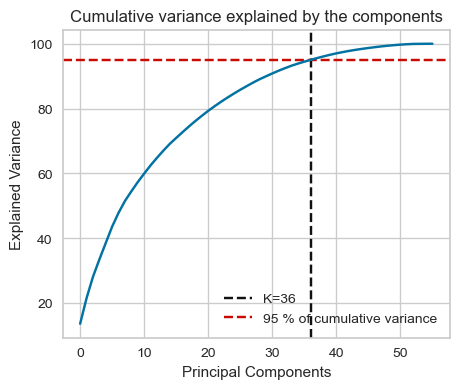

In [90]:
# Check how many components are actually needed for out model, by looking at the cumulative variance
var_cum = np.cumsum(pca.explained_variance_ratio_)*100
 
# number of principal components thet explain 95% of the variance 
# (code taken and adapted from Dr. Ilin's week 8 live session notebook: "dimensionality reduction")

k = np.argmax(var_cum>95)
print("Number of principal components explaining 95% of variance: "+ str(k))
 
plt.figure(figsize=[5,4])
plt.title('Cumulative variance explained by the components')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.axvline(x=k, color="k", linestyle="--", label = "K=36")
plt.axhline(y=95, color="r", linestyle="--", label="95 % of cumulative variance")
ax = plt.plot(var_cum)
              
plt.legend()

In [91]:
# rerun again with 36 components
pca = PCA(n_components=36) 
pca.fit(X_train_std)

# Rename the columns
columns = []
for i in range(pca.n_components):
    columns.append('PCA{}'.format(i + 1))

# transform both the train and the test set to guarantee same principal components when testing the model 
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [92]:
# remake train and test dfs with pcas
train_df_pca = pd.concat(
    [pd.DataFrame(X_train_pca, columns=columns),pd.DataFrame(y_train, columns=['Class'])],
    axis=1
)

test_df_pca = pd.concat(
    [pd.DataFrame(X_test_pca, columns=columns),pd.DataFrame(y_test, columns=['Class'])],
    axis=1
)


## Fit the model
----

In [93]:
rf = RandomForestClassifier(oob_score=True,random_state=42,criterion='entropy') #oob_score included to evaluate error

In [94]:
# fitting a basic model, without hypertuning
rf.fit(X_train_pca, y_train)

RandomForestClassifier(criterion='entropy', oob_score=True, random_state=42)

In [95]:
# out-of-bag error
oob_error = 1 - rf.oob_score_
print(f'OOB score: {rf.oob_score_:.3f}')
print(f'OOB error: {oob_error:.3f}')


OOB score: 0.776
OOB error: 0.224


## Evaluate the model



In [96]:
# Define the scoring dictionary
scoring = {
    'roc_auc': 'roc_auc',
    'log_loss': 'neg_log_loss'
}

# cross validate using 10 folds, since sample size is low
scores = cross_validate(rf, X_train_pca, y_train, n_jobs=-1, cv=10, scoring=scoring, return_train_score=True)

# Training and validation Log Loss. The minus sign was added to "invert" the log loss because random forest's log los metric is negative log loss
print("Training log loss. Mean: %0.2f, Standard deviation: %0.2f" % (-scores['train_log_loss'].mean(),scores['train_log_loss'].std()))
print("Validation log loss. Mean: %0.2f Standard deviation: %0.2f" % (-scores['test_log_loss'].mean(),scores['test_log_loss'].std()))

print("-"*50)
# Training and validation average roc_auc
print("Training balanced roc_auc. Mean: %0.2f, Standard deviation: %0.2f" % (scores['train_roc_auc'].mean(),scores['train_roc_auc'].std()))
print("Validation balanced roc_auc. Mean: %0.2f Standard deviation: %0.2f" % (scores['test_roc_auc'].mean(),scores['test_roc_auc'].std()))



Training log loss. Mean: 0.15, Standard deviation: 0.00
Validation log loss. Mean: 0.51 Standard deviation: 0.07
--------------------------------------------------
Training balanced roc_auc. Mean: 1.00, Standard deviation: 0.00
Validation balanced roc_auc. Mean: 0.88 Standard deviation: 0.08


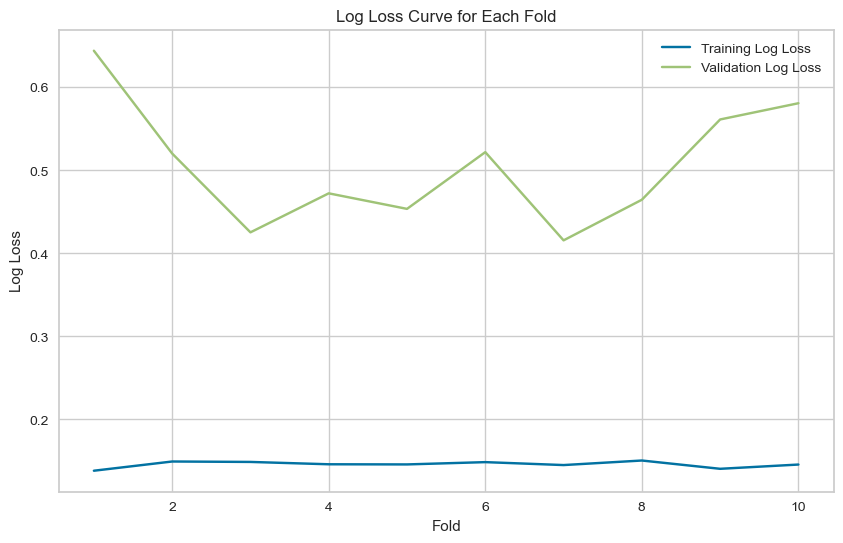

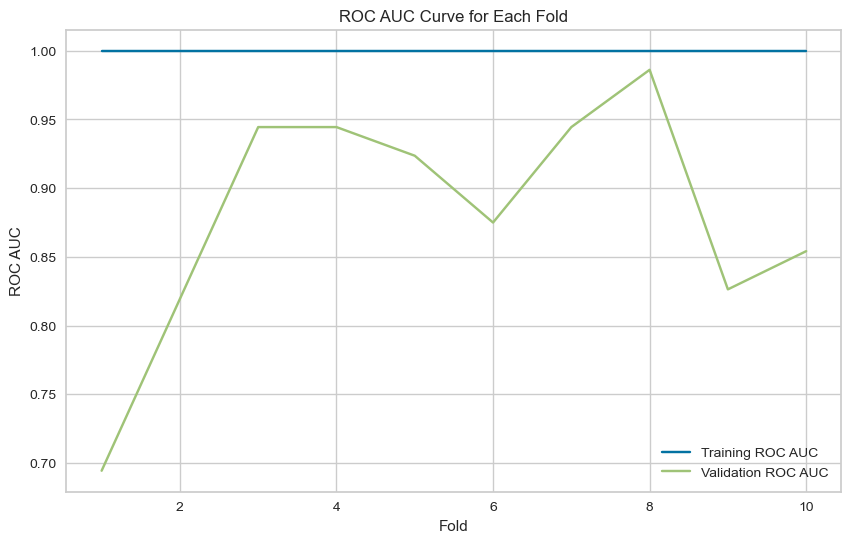

In [98]:
# Plotting roc_auc and log loss for each fold
train_log_loss = -scores['train_log_loss']
val_log_loss = -scores['test_log_loss']
train_roc_auc = scores['train_roc_auc']
val_roc_auc = scores['test_roc_auc']

# Get the number of folds
num_folds = len(train_log_loss)

# Create an array with the fold numbers 
fold_numbers = np.arange(1, num_folds + 1)

# Plot log loss curves
plt.figure(figsize=(10, 6))
plt.plot(fold_numbers, train_log_loss, label='Training Log Loss')
plt.plot(fold_numbers, val_log_loss, label='Validation Log Loss')
plt.xlabel('Fold')
plt.ylabel('Log Loss')
plt.title('Log Loss Curve for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC AUC curves
plt.figure(figsize=(10, 6))
plt.plot(fold_numbers, train_roc_auc, label='Training ROC AUC')
plt.plot(fold_numbers, val_roc_auc, label='Validation ROC AUC')
plt.xlabel('Fold')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Curve for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

Evaluating the influence of a single hyperparameter: number of trees

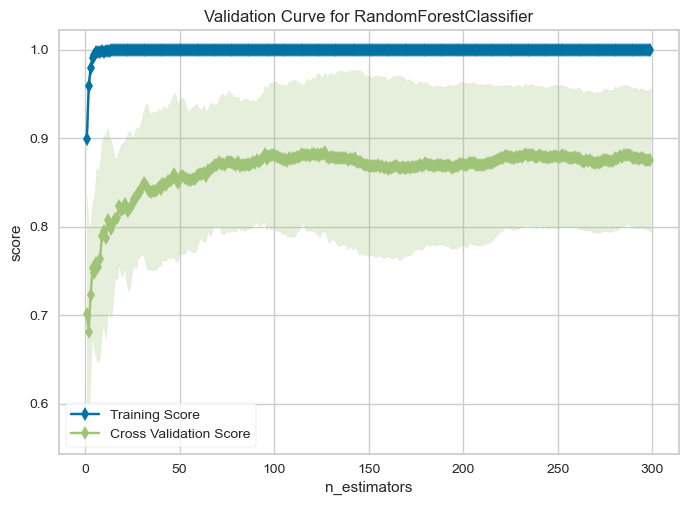

<Axes: title={'center': 'Validation Curve for RandomForestClassifier'}, xlabel='n_estimators', ylabel='score'>

In [99]:
# Evaluate the validation curve on the number of trees
viz = ValidationCurve(rf, param_name="n_estimators", n_jobs=-1,
     param_range=np.arange(1, 300), cv=10, scoring="roc_auc")

viz.fit(X_train_pca, y_train)
viz.show()

Vizualize a sample tree

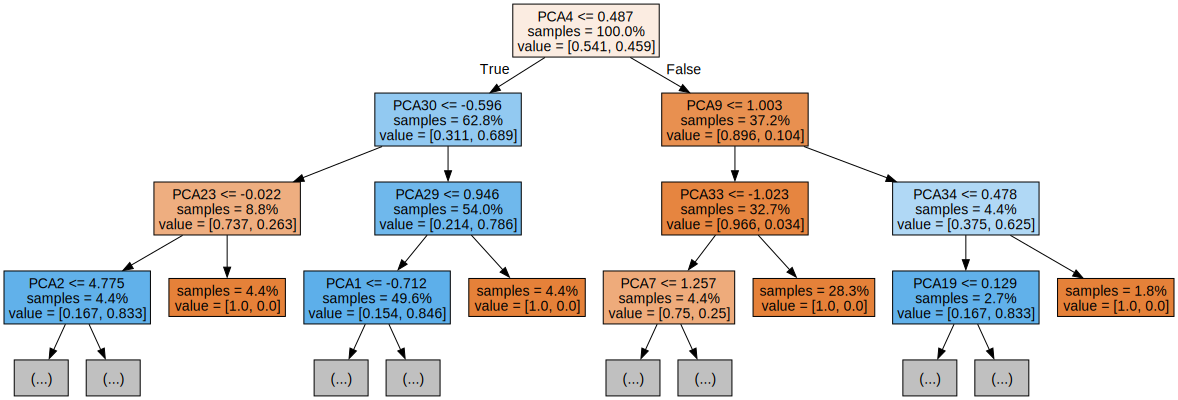

In [100]:
# Export the first decision tree from the forest
columns = [i for i in train_df_pca.columns if i not in ['Class']]


for i in range(1):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=columns,
                               filled=True,
                               max_depth=3, # tree of depth 3
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Fit the best model to whole training set after k-fold cross-validation

# Hyperparameter tuning
----

In [104]:
#hyperparameter tuning: 
hyperparameter_space = {'n_estimators': [100,200,500,1000], #number of trees default=100
                         'max_depth': [3, 5, 10]} #depth of trees

scoring_metrics = {
    'roc_auc': 'roc_auc',
    'log_loss': 'neg_log_loss'
}

# GridSearchCV for ROC AUC
gs_roc_auc = GridSearchCV(rf, param_grid=hyperparameter_space, cv=10, n_jobs=-1, scoring='roc_auc', refit='roc_auc')
gs_roc_auc.fit(X_train_pca, y_train)

# GridSearchCV for log loss
gs_log_loss = GridSearchCV(rf, param_grid=hyperparameter_space, cv=10, n_jobs=-1, scoring='neg_log_loss', refit='neg_log_loss')
gs_log_loss.fit(X_train_pca, y_train)

# Access the best models for roc_auc and log loss
best_model_roc_auc = gs_roc_auc.best_estimator_
best_model_log_loss = gs_log_loss.best_estimator_

# Access the best hyperparameters for roc_auc and log loss
best_params_roc_auc = gs_roc_auc.best_params_
best_params_log_loss = gs_log_loss.best_params_

In [105]:
print("Best model for roc_auc: ", best_model_roc_auc)
print("Best model for log loss: ", best_model_log_loss)

print("Optimal hyperparameter combination for roc_auc: ", best_params_roc_auc)
print("Optimal hyperparameter combination for log loss: ", best_params_log_loss)

Best model for roc_auc:  RandomForestClassifier(criterion='entropy', max_depth=5, oob_score=True,
                       random_state=42)
Best model for log loss:  RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000,
                       oob_score=True, random_state=42)
Optimal hyperparameter combination for roc_auc:  {'max_depth': 5, 'n_estimators': 100}
Optimal hyperparameter combination for log loss:  {'max_depth': 10, 'n_estimators': 1000}


# Fit best model

---

In [106]:
# the best model in terms of log loss was selected 
best_model = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000,
                       oob_score=True, random_state=42)

best_model.fit(X_train_pca, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000,
                       oob_score=True, random_state=42)

# Evaluate best model
---

In [107]:
scoring = {
    'roc_auc': 'roc_auc',
    'log_loss': 'neg_log_loss'
}

scores = cross_validate(best_model, X_train_pca, y_train, n_jobs=-1, cv=10, scoring=scoring, return_train_score=True)


#Training and validation Log Loss
print("Training log loss. Mean: %0.2f, Standard deviation: %0.2f" % (-scores['train_log_loss'].mean(),scores['train_log_loss'].std()))
print("Validation log loss. Mean: %0.2f Standard deviation: %0.2f" % (-scores['test_log_loss'].mean(),scores['test_log_loss'].std()))

print("-"*50)
# Training and validation average roc_auc
print("Training roc_auc. Mean: %0.2f, Standard deviation: %0.2f" % (scores['train_roc_auc'].mean(),scores['train_roc_auc'].std()))
print("Validation roc_auc. Mean: %0.2f Standard deviation: %0.2f" % (scores['test_roc_auc'].mean(),scores['test_roc_auc'].std()))

Training log loss. Mean: 0.15, Standard deviation: 0.00
Validation log loss. Mean: 0.50 Standard deviation: 0.07
--------------------------------------------------
Training roc_auc. Mean: 1.00, Standard deviation: 0.00
Validation roc_auc. Mean: 0.88 Standard deviation: 0.08


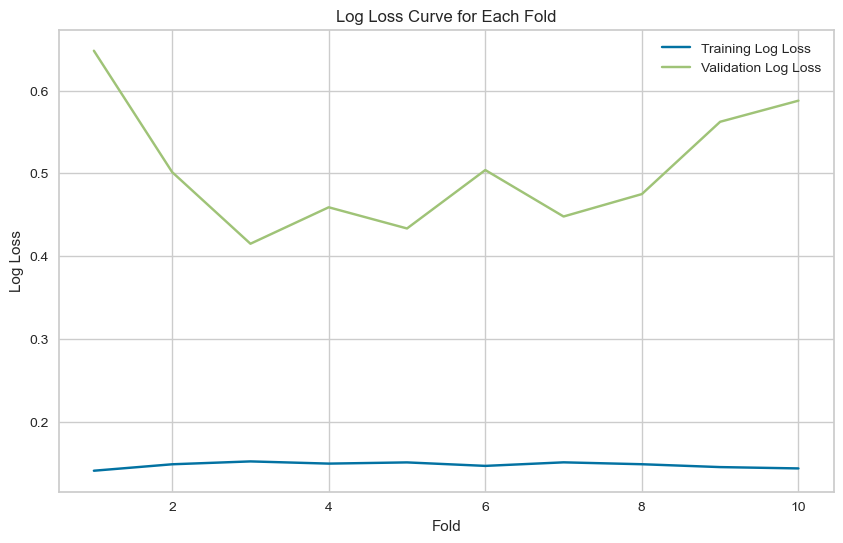

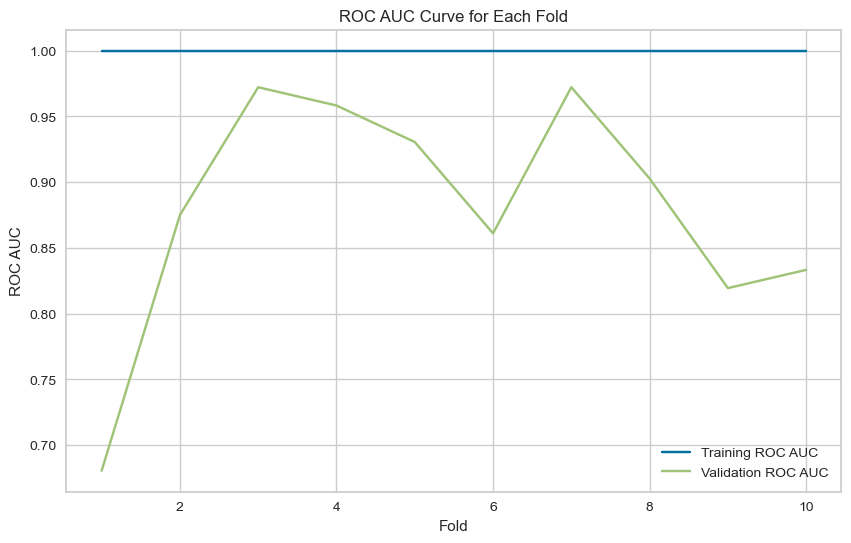

In [108]:
train_log_loss = -scores['train_log_loss']
val_log_loss = -scores['test_log_loss']
train_roc_auc = scores['train_roc_auc']
val_roc_auc = scores['test_roc_auc']

# Get the number of folds
num_folds = len(train_balanced_log_loss)

# Create an array with the fold numbers 
fold_numbers = np.arange(1, num_folds + 1)

# Plot  log loss curves
plt.figure(figsize=(10, 6))
plt.plot(fold_numbers, train_log_loss, label='Training Log Loss')
plt.plot(fold_numbers, val_log_loss, label='Validation Log Loss')
plt.xlabel('Fold')
plt.ylabel('Log Loss')
plt.title('Log Loss Curve for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC AUC curves
plt.figure(figsize=(10, 6))
plt.plot(fold_numbers, train_roc_auc, label='Training ROC AUC')
plt.plot(fold_numbers, val_roc_auc, label='Validation ROC AUC')
plt.xlabel('Fold')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Curve for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

Evaluating the influence of a single hyperparameter (number of trees) on roc_auc, for the best model

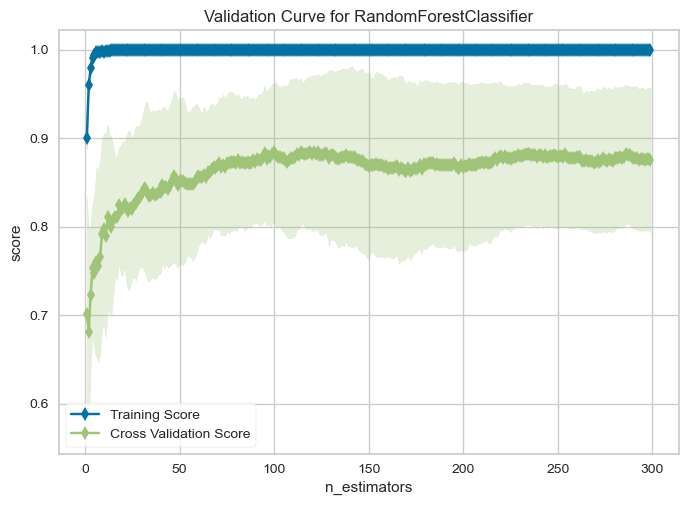

<Axes: title={'center': 'Validation Curve for RandomForestClassifier'}, xlabel='n_estimators', ylabel='score'>

In [109]:
roc_viz = ValidationCurve(best_model, param_name="n_estimators", n_jobs=-1,
     param_range=np.arange(1, 300), cv=10, scoring="roc_auc")


roc_viz.fit(X_train_pca, y_train)
roc_viz.show()

Evaluating the influence of a single hyperparameter (number of trees) on negative log loss, for the best model

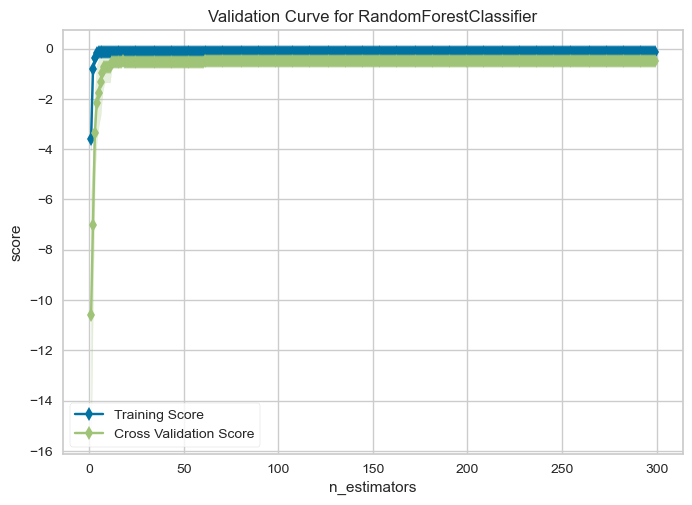

<Axes: title={'center': 'Validation Curve for RandomForestClassifier'}, xlabel='n_estimators', ylabel='score'>

In [110]:
# the loss curve is inverted because the log loss which is calculated in decision trees is negative log loss
los_viz = ValidationCurve(best_model, param_name="n_estimators", n_jobs=-1,
     param_range=np.arange(1, 300), cv=10, scoring="neg_log_loss")


los_viz.fit(X_train_pca, y_train)
los_viz.show()

# Predict

----

In [111]:
# Generate predictions with the best model
y_pred = best_model.predict(X_test_pca)

print("MODEL ROC_AUC: ", roc_auc_score(y_test, y_pred))
print("MODEL LOG LOSS: ", log_loss(y_test, y_pred))



MODEL ROC_AUC:  0.7378390012914335
MODEL LOG LOSS:  10.464286467808208


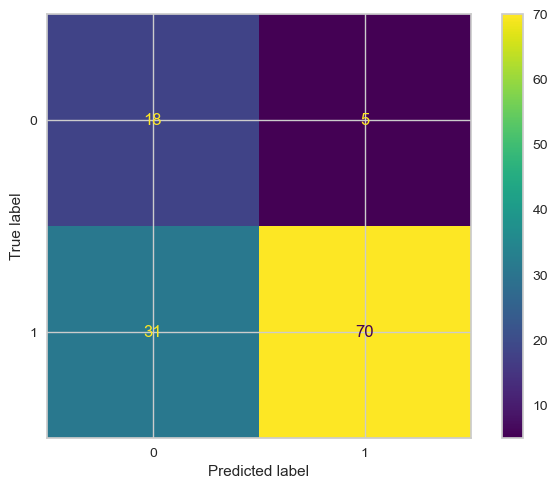

In [112]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Conclusions

---

1. Train, cross-validation and test valuest for the best model: 

||roc_auc|log_loss|
|---|---|---|
|Train|1.00|0.15|
|Validation|0.88|0.50|
|Test|0.73|10.46|

- Large value for false negative (Class 1 predicted as 0). This may be because of the downsampling to the minority class 
- The really large loss in the test set may be do to overfitting, or to the class imbalance in test_df, since it is not downsampled, to avoid data leakage. This is visible in the roc_auc = 1 for the training set. It may also be due to the small sample size, or to how the data was split. 


2. Future options: 
- Use other strategies to deal with class imbalance (SMOTE, balanced log loss)
- Try XGBoost or AdaBoost
- Hypertune other parameters, such as number of features or number of samples required to split a node


